In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_HEIGHT = 208
IMAGE_WIDTH = 176
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "alzheimers_dataset",
    shuffle = True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 6281 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 208, 176, 3)
[2 2 0 3 2 2 2 2 2 3 3 3 3 2 3 2 3 3 2 3 2 3 0 2 3 2 2 3 3 3 0 3]


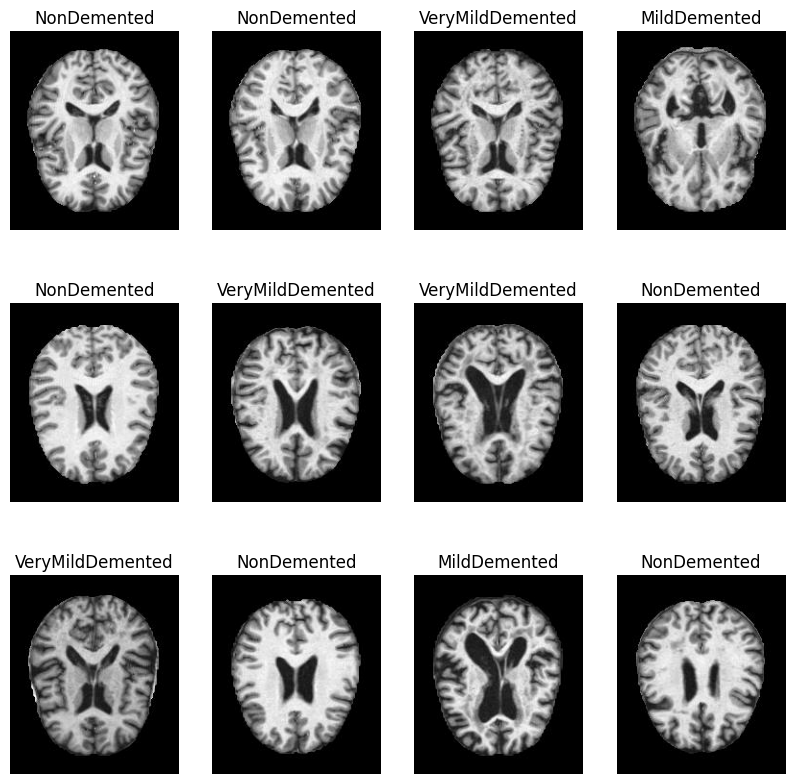

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

197

In [8]:
train_size = 0.8
len(dataset) * train_size

157.60000000000002

In [9]:
train_ds = dataset.take(157)
len(train_ds)

157

In [10]:
test_ds = dataset.skip(157)
len(test_ds)

40

In [11]:
val_size = 0.1
len(dataset) * val_size

19.700000000000003

In [12]:
val_ds = test_ds.take(19)
len(val_ds)

19

In [13]:
test_ds = test_ds.skip(19)
len(test_ds)

21

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

157

In [17]:
len(val_ds)

19

In [18]:
len(test_ds)

21

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 208, 176, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 206, 174, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 103, 87, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 101, 85, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 50, 42, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 48, 40, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())

Is CUDA available:  False
Number of GPUs:  0


In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50




KeyboardInterrupt: 